In [1]:
import sys
#sys.path.append("C:\\Users\\anbro\\Documents\\projects\\opendrift")
sys.path.append("/home/martinls/src/opendrift")

In [2]:
%matplotlib notebook

In [3]:
try:
    from line_profiler import LineProfiler

    def do_line_profile(follow=[]):
        def inner(func):
            def profiled_func(*args, **kwargs):
                try:
                    profiler = LineProfiler()
                    profiler.add_function(func)
                    for f in follow:
                        profiler.add_function(f)
                    profiler.enable_by_count()
                    return func(*args, **kwargs)
                finally:
                    profiler.print_stats()
            return profiled_func
        return inner

except ImportError:
    def do_line_profile(follow=[]):
        "Helpful if you accidentally leave in production!"
        def inner(func):
            def nothing(*args, **kwargs):
                return func(*args, **kwargs)
            return nothing
        return inner
    
def get_number():
    a = xrange(500000)
    for x in a:
        yield x

@do_line_profile(follow=[])
def expensive_function():
    for x in get_number():
        i = x ^ x ^ x
    return 'some result!'

result = expensive_function()
print result

some result!


In [4]:
from opendrift.models.leeway import Leeway
from opendrift.models.oceandrift import OceanDrift
from opendrift.models.openoil3D import OpenOil3D

from opendrift.readers import reader_netCDF_CF_generic
from opendrift.readers import reader_basemap_landmask
from opendrift.readers.interpolation import ReaderBlock

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(983214)

In [5]:
import netCDF4 as nc

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [6]:
#filename = 'norkyst800_subset_16Nov2015.nc'
#ncfile = nc.Dataset(filename, 'r')
#nc_attrs, nc_dims, nc_vars = ncdump(ncfile, verb=False)#

#x = np.array(ncfile.variables['X'])
#y = np.array(ncfile.variables['Y'])

#ncfile.close()

In [7]:
filename='data/2LayerTestLargeWithCoriolis.nc'
ncfile = nc.Dataset(filename, 'r')
nc_attrs, nc_dims, nc_vars = ncdump(ncfile, verb=False)

u = np.array(ncfile.variables['u'])
v = np.array(ncfile.variables['v'])
x = np.array(ncfile.variables['x'])
y = np.array(ncfile.variables['y'])
t = np.array(ncfile.variables['time'])

ncfile.close()

w = np.sqrt(u*u+v*v)

timestep = 1

#print 'timestep = ', t
#print 'x = ', x
#print 'y = ', y

plt.figure()
plt.imshow(w[timestep, :, :])
plt.colorbar()

IOError: No such file or directory

In [12]:
def getCenter(reader):
    dims = np.array([reader.numx, reader.numy])
    center_xy = [reader.x[dims[0]/2], reader.y[dims[1]/2]]
    #print reader.x[dims[0]/2], reader.y[dims[1]/2]
    [lon, lat] = reader.xy2lonlat(center_xy[0], center_xy[1])
    return lon, lat

reader_arctic = reader_netCDF_CF_generic.Reader(filename)
reader_arctic.buffer = 10
reader_arctic.verticalbuffer = 0
lon, lat = getCenter(reader_arctic)

#reader_basemap = reader_basemap_landmask.Reader(
#                       llcrnrlon=5, llcrnrlat=55,
#                       urcrnrlon=15, urcrnrlat=65,
#                       resolution='h', projection='merc')

print reader_arctic
#print reader_basemap

#lat = lat -10 #Issue around +90 lat, just make sure everything is less.

print lon, lat

#plt.figure()
#reader_basemap.plot()

Reader: data/2LayerTestLargeWithCoriolis.nc
Projection: 
  +proj=stere +lat_0=90 +lon_0=70 +lat_ts=60 +units=m +a=6.371e+06 +e=0 +no_defs
Coverage: [m]
  xmin: 0.000000   xmax: 250000.000000   step: 490.196   numx: 511
  ymin: 0.000000   ymax: 350000.000000   step: 342.466   numy: 1023
  Corners (lon, lat):
    (-110.00,  86.63)  (-145.54,  85.86)
    ( 70.00,  90.00)  (160.00,  87.59)
Vertical levels [m]: 
  Not specified
Available time range:
  start: 1970-01-01 00:00:00   end: 1970-01-01 02:54:00   step: 0:06:00
    30 times (0 missing)
Variables:
  land_binary_mask
  y_sea_water_velocity
  x_sea_water_velocity
  time

-145.537677792 87.927302259


<IPython.core.display.Javascript object>


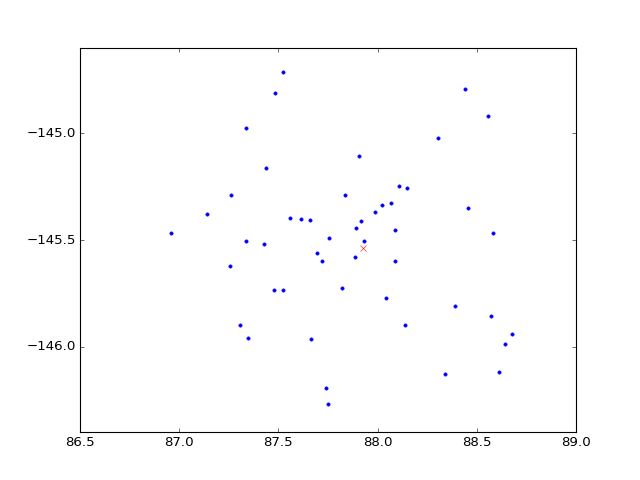

In [13]:
def sampleParticles(particles, radius_max, center_lat, center_lon):

    angle = np.random.rand(particles) * np.pi * 2
    radius = np.random.rand(particles)*radius_max

    lats = center_lat + np.sin(angle)*radius
    lons = center_lon + np.cos(angle)*radius
    
    return lats, lons


num_particles = 50
max_radius = 1
lat_array, lon_array = sampleParticles(num_particles, max_radius, lat, lon)

plt.figure()
plt.plot(lat, lon, 'rx')
plt.plot(lat_array, lon_array, '.')

plot_axis = plt.axis()

In [14]:
def simulate(lon, lat, reader, start_time, end_time, reader_land_mask=None):
    o = OceanDrift(loglevel=50) # Quiet
    o.add_reader(reader) # with land mask from reader
    #o.add_reader([reader_land_mask, reader]) # with land mask from reader_land_mask
    #o.fallback_values['x_wind'] = 10
    #o.fallback_values['y_wind'] = -10
    o.fallback_values['x_sea_water_velocity'] = 0.001
    o.fallback_values['y_sea_water_velocity'] = 0.001
    o.fallback_values['land_binary_mask'] = 0
    #o.set_config('processes:turbulentmixing', False)
    #o.set_config('general:coastline_action', 'none')

    print 'start time = ', start_time
    print 'end time = ', end_time
    num_timesteps = 10
    num_particles = len(lat)

    o.seed_elements(lat=lat, lon=lon, number=num_particles, radius=1, time=start_time)

    dt = (end_time - start_time).total_seconds() / num_timesteps
    o.run(end_time=end_time, time_step=dt)
    #o.run(steps=2)
    
    particleid=slice(None)
    timesteps=slice(None)
    lat_out=np.transpose(o.history['lat'][particleid, timesteps])
    lon_out=np.transpose(o.history['lon'][particleid, timesteps])
    
    return lat_out, lon_out

    
lat_out, lon_out = simulate(lon_array, lat_array, reader_arctic, reader_arctic.start_time, reader_arctic.end_time)#, reader_basemap)
print 'Timesteps, num_particles'
print lat_out.shape

start time =  1970-01-01 00:00:00
end time =  1970-01-01 02:54:00
Timesteps, num_particles
(11, 50)


In [15]:
#plt.figure()
#o.plot(liecolor='z', background=['x_sea_water_velocity', 'y_sea_water_velocity'])

<IPython.core.display.Javascript object>


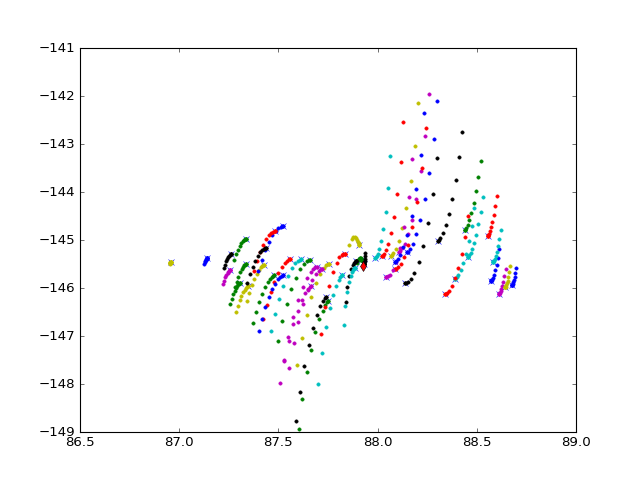

''

In [16]:
#extents = [reader_arctic.xmin, reader_arctic.xmax, reader_arctic.ymin, reader_arctic.ymax]
#lat_lon_extents = extents;
#lat_lon_extents[0], lat_lon_extents[2] = reader_arctic.xy2lonlat(extents[0], extents[2]);
#lat_lon_extents[1], lat_lon_extents[3] = reader_arctic.xy2lonlat(extents[1], extents[3]);

#print extents
#print lat_lon_extents

plt.figure()
#plt.axis(plot_axis)
plt.plot(lat_array, lon_array, 'x')
plt.plot(lat_out, lon_out, '.')
plt.plot(lat, lon, 'd')
;

### SIR functions

In [21]:
# Simple implementation of sequential importance filter for 
# observed drifter positions.
#
# kaihc@met.no - 20170329

def getWeights(xpos, ypos, xobs, yobs, R):

    """
    Calculation of weights for the sequential importance resampling (SIR) filter.

    Inputs: xpos, ypos  - vectors with end positions from ensemble 
                          of trajectory simulations
            xobs, yobs  - observed end position of drifter
            R           - observation error variance
            
    Output: w           - weight of each particle (normalized)
    """
    
    # Calculate innovations, obs-model
    d = np.array([np.sqrt( (xobs-xpos[i])**2 + (yobs-ypos[i])**2 ) for i in range(len(xpos))])

    # Introduce temporary variable for weight calculation (not strictly necessary for our
    # simple example, but important for multiple observations and larger state space).
    v = d/R

    # Temporary variable for better numerical properties.
    wmin = np.min(-0.5*d*v)

    # Calculate weights
    w = np.exp(-0.5*d*v + wmin)

    # Normalize weights
    w = w/np.sum(w)

    return w           



def resample(w):

    """
    Resampling using SIR (van Leuween, 2009, Sec. 3a).

    Input:  w           - weights

    Output: nsamples    - number of samples of each particle
    """

    # Number of weights
    N = len(w)

    # Random number for resampling intervals
    rnum = np.random.random_sample()

    # Intervals for resampling
    rarray = (rnum + np.arange(N))/N

    # Line up weights
    warray = np.concatenate(([0],np.cumsum(w)))

    # Get samples per particle
    nsamples, rw = np.histogram(rarray, bins=warray)

    return nsamples


### Example
#np.random.seed(43)
#
#x = np.random.rand(10)
#y = np.random.rand(10)
#
#w = getWeights(x,y,0.9,0.1,0.1)
#
#r = resample(w)

In [22]:
def resample_particles(particles, weights, radius_max):

    
    
    angle = np.random.rand(particles) * np.pi * 2
    radius = np.random.rand(particles)*radius_max

    lats = center_lat + np.sin(angle)*radius
    lons = center_lon + np.cos(angle)*radius
    
    return lats, lons


-145.537677792 87.927302259
50


<IPython.core.display.Javascript object>


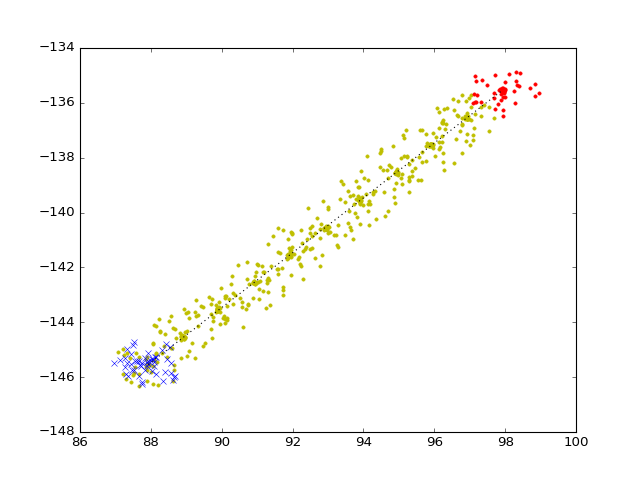

''

In [27]:
print lon, lat


#print resamples


def step(prev_lats, prev_lons, obs_lat, obs_lon):
    weights = getWeights( prev_lons,  prev_lats, obs_lon, obs_lat, R=0.001)

    resamples = resample(weights)
    N = len(weights)
    new_lons = np.array([])
    new_lats = np.array([]) #np.zeros_like(lat_array)

    #print 'Resamples = ', np.sum(resamples == 0)

    for i in range(N):
        r = resamples[i]
        if (r == 0):
            continue

        new_lons = np.append(new_lons, prev_lons[i])
        new_lats = np.append(new_lats, prev_lats[i])
        
        resampled_lats, resampled_lons = sampleParticles(center_lat=prev_lats[i], center_lon=prev_lons[i], particles=r-1, radius_max=max_radius)
        new_lons = np.append(new_lons, resampled_lons)
        new_lats = np.append(new_lats, resampled_lats)

    return new_lats, new_lons


lat_obs = np.array([lat])
lon_obs = np.array([lon])

new_lats, new_lons = step(lat_array, lon_array, lat_obs[-1], lon_obs[-1])
print(new_lats.size)

plt.figure()

for i in range(1000):
    lat_obs = np.append(lat_obs, lat_obs[-1] + 0.01)
    lon_obs = np.append(lon_obs, lon_obs[-1] + 0.01)
    new_lats, new_lons = step(new_lats, new_lons, lat_obs[-1], lon_obs[-1])
    if i%100 == 0:
        plt.plot(new_lats, new_lons, '.y')


#print new_lons
#print new_lats
    

#plt.axis(plot_axis)
plt.plot(lat_array, lon_array, 'x')
#plt.plot(lat_out, lon_out, '.')
#plt.plot(lat, lon, 'd')
#plt.plot(lat_array[(resamples == 0)], lon_array[(resamples == 0)], 'sg')
#plt.plot(lat_array[(resamples != 0)], lon_array[(resamples != 0)], 'd')
plt.plot(new_lats, new_lons, '.r')

plt.plot(lat_obs, lon_obs, 'k:')



;



